In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

* Design a query to retrieve the last 12 months of precipitation data and plot the results

* Calculate the date 1 year ago from the last data point in the database

* Perform a query to retrieve the data and precipitation scores

* Save the query results as a Pandas DataFrame and set the index to the date column

* Sort the dataframe by date

* Use Pandas Plotting with Matplotlib to plot the data


In [14]:
# Find date of last entry in the data table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [16]:
# Get the date 365 days from the last date.
last_date_plus365 = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_date_plus365)

2016-08-23


In [17]:
# Retrieve the last 12 months of precipitation data
one_yr_percip = session.query(Measurement.date, Measurement.prcp).\
                        filter(Measurement.date > last_date_plus365).\
                        order_by(Measurement.date).all()

In [22]:
# Load the results into a pandas dataframe.

precipitation_df = pd.DataFrame(one_yr_percip, columns=['Date', 'Percipitation'])

# Change the date to a datetime format.
precipitation_df['Date'] = pd.to_datetime(precipitation_df['Date'], format='%Y/%m/%d')

#Reset the index to the 'Date'
precipitation_df.set_index(precipitation_df['Date'], inplace=True)
precipitation_df.head()

,Date,Percipitation
Date,,
2016-08-24,2016-08-24,0.08
2016-08-24,2016-08-24,2.15
2016-08-24,2016-08-24,2.28
2016-08-24,2016-08-24,NaN
2016-08-24,2016-08-24,1.22


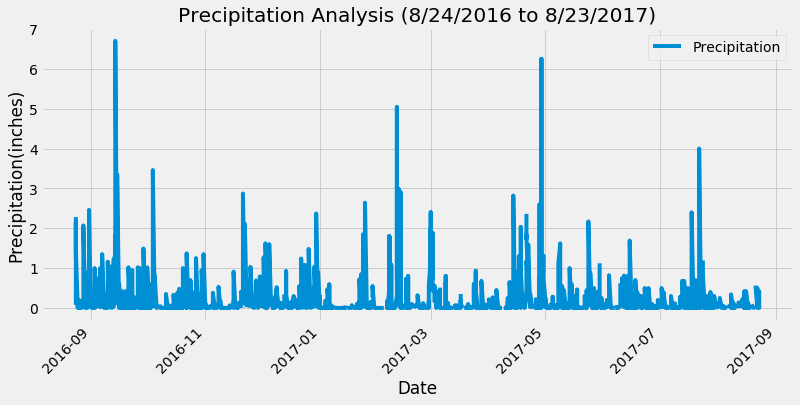

In [23]:
# Plot the dataframe as a horizontal bar chart using pandas plotting

precipitation_df.plot('Date', 'Percipitation',figsize=(12,6))
plt.xlabel("Date")
plt.ylabel("Precipitation(inches)")
plt.title("Precipitation Analysis (8/24/2016 to 8/23/2017)")
plt.xticks(rotation=45)
plt.show()

In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Percipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.id)).all()
station_count

[(9)]

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations = (session
                        .query(Measurement.station, func.count(Measurement.id))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.id).desc())
                        .all())
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_records_top_station = (session
                        .query(func.min(Measurement.tobs),
                               func.max(Measurement.tobs),
                               func.avg(Measurement.tobs))
                        .filter(Measurement.station == most_active_stations[0][0])
                        .all())    
    
temp_records_top_station

[(54.0, 85.0, 71.66378066378067)]

In [33]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
my_station_histogram = (session
                        .query(Measurement.date, Measurement.tobs)
                        .filter(Measurement.date > last_date_plus365, 
                                Measurement.station == most_active_stations[0][0])
                        .all())  
my_station_histogram_df = pd.DataFrame(my_station_histogram, columns=["Date", "Tobs"])
my_station_histogram_df["Date"] = pd.to_datetime(my_station_histogram_df["Date"])
my_station_histogram_df.head()

,Date,Tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


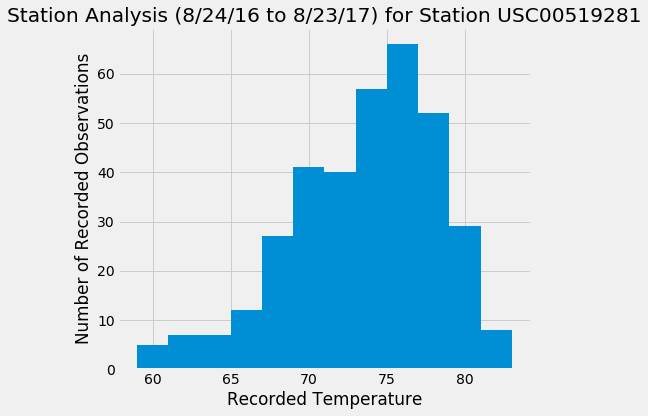

In [38]:
plt.figure(figsize=(8,6))
plt.hist(my_station_histogram_df["Tobs"],bins = 12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active_stations[0][0])
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
